In [1]:
# install new lib if missing
# !pip install geopy
# !pip install graphviz pydot
!pip install autogluon
# !pip install pprintpp

# !pip uninstall -y numpy scikit-learn
# !pip install numpy scikit-learn

# !pip install numpy==1.22.4
# !pip install scikit-learn==0.24.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.2/266.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

# Import library and check versions

In [3]:
import os
import numpy as np
import pandas as pd # data processing, CSV file I/O lib
# visual lib
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning lib
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.neighbors import NearestNeighbors

import xgboost as xgb # Extreme Gradient Boosting

# tensorflow lib
# import tensorflow.compat.v2 as tf 
# from tensorflow.keras.layers import Dense, Input
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import DenseFeatures

# autogluon lib
# from autogluon.tabular import TabularDataset, TabularPredictor

# pretty print
from pprint import pprint

In [6]:
# check lib version
# !pip install --upgrade tensorflow
# print(tf.__version__)
print(np.__version__)
print(pd.__version__)

import sklearn
print(sklearn.__version__)  

1.26.4
2.2.3
1.5.2


# Load/read movies data

In [49]:
top_250_movies = pd.read_csv("/kaggle/input/imdb-top-250-movies-dataset/IMDB Top 250 Movies.csv")

# check shape
print('data shape=',top_250_movies.shape)
print('data columns=', top_250_movies.columns)

# check duplicated movies
if top_250_movies["name"].duplicated().sum() == 0:
    print("There are no duplicated values")
else:
    print("Duplicated values identified")

# no missing values
top_250_movies.head(2)

data shape= (250, 13)
data columns= Index(['rank', 'name', 'year', 'rating', 'genre', 'certificate', 'run_time',
       'tagline', 'budget', 'box_office', 'casts', 'directors', 'writers'],
      dtype='object')
There are no duplicated values


,rank,name,year,rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers
0,1,The Shawshank Redemption,1994,9.3,Drama,R,2h 22m,Fear can hold you prisoner. Hope can set you f...,25000000,28884504,"Tim Robbins,Morgan Freeman,Bob Gunton,William ...",Frank Darabont,"Stephen King,Frank Darabont"
1,2,The Godfather,1972,9.2,"Crime,Drama",R,2h 55m,An offer you can't refuse.,6000000,250341816,"Marlon Brando,Al Pacino,James Caan,Diane Keato...",Francis Ford Coppola,"Mario Puzo,Francis Ford Coppola"


In [8]:
top_250_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rank         250 non-null    int64  
 1   name         250 non-null    object 
 2   year         250 non-null    int64  
 3   rating       250 non-null    float64
 4   genre        250 non-null    object 
 5   certificate  250 non-null    object 
 6   run_time     250 non-null    object 
 7   tagline      250 non-null    object 
 8   budget       250 non-null    object 
 9   box_office   250 non-null    object 
 10  casts        250 non-null    object 
 11  directors    250 non-null    object 
 12  writers      250 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 25.5+ KB


In [11]:
# sample data
Forrest = top_250_movies[top_250_movies['name'].str.contains('Forrest')]
display('阿甘正传', Forrest)

Shawshank = top_250_movies[top_250_movies['rank'] == 1]
Shawshank

'阿甘正传'

,rank,name,year,rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers
10,11,Forrest Gump,1994,8.8,"Drama,Romance",PG-13,2h 22m,The story of a lifetime.,55000000,678226465,"Tom Hanks,Robin Wright,Gary Sinise,Sally Field...",Robert Zemeckis,"Winston Groom,Eric Roth"


,rank,name,year,rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers
0,1,The Shawshank Redemption,1994,9.3,Drama,R,2h 22m,Fear can hold you prisoner. Hope can set you f...,25000000,28884504,"Tim Robbins,Morgan Freeman,Bob Gunton,William ...",Frank Darabont,"Stephen King,Frank Darabont"


# My useful tool function

In [78]:

def cal_profit_perc(data):
     return (float(data['box_office']) - float(data['budget']) ) / float(data['budget']) * 100

print(f"Shawshank profit_perc {cal_profit_perc(Shawshank):.2f}%")
print(f"Forrest profit_perc {cal_profit_perc(Forrest):.2f}%")


def get_condition_filter(tar_data, col):
    # convert rating to numeric
    convert_data = pd.to_numeric(tar_data[col], errors='coerce')
    return convert_data.isna(), convert_data.notna()

# auto calculate bin width, according data distribution
def histogram(data, column, bins_method='auto'):
    plt.figure(figsize=(6,4))
    if bins_method == 'auto':
        plt.hist(data[column], bins='auto', alpha=0.7, color='#539caf', rwidth=0.85)
        plt.title(f'auto bin with hist for {column}')

    if bins_method == 'fd':
        '''
        # Freedman-Diaconis bin width
        Q1 = np.percentile(data, 25) # 第25百分位数
        Q3 = np.percentile(data, 75) # 第75百分位数
        iqr_data = Q3 - Q1 # 四分位距(IQR)
        
        n = len(data)
        # Freedman-Diaconis bin宽度
        bin_width_fd = 2 * iqr_data / (n ** (1/3))
        bins_fd = int((data.max() - data.min()) / bin_width_fd)
        '''
        plt.hist(data[column], bins='fd', alpha=0.7, color='#539caf', rwidth=0.85)
        plt.title(f'Freedman-Diaconis bin with hist for {column}')
    
    if bins_method == 'scott':
        '''
        # Scott's bin width
        std_dev = np.std(data)
        bin_width_scott = 3.5 * std_dev / (n ** (1/3))
        bins_scott = int((data.max() - data.min()) / bin_width_scott)
        '''
        plt.hist(data[column], bins='scott', alpha=0.7, color='#539caf', rwidth=0.85)
        plt.title(f'Scott bin with hist for {column}')
        
    plt.show()


import re
def time_str2minutes(time_str):
    pattern = r"(?:(\d+)h)?\s*(?:(\d+)m)?"
    
    match = re.match(pattern, time_str)
    hours = 0
    minutes = 0
    
    if match:
        hours = 0 if match.group(1) is None else int(match.group(1))  
        minutes = 0 if match.group(2) is None else int(match.group(2))  

    # print(hours, minutes)
    if hours > 0 or minutes > 0:
        return hours * 60 + minutes
    else:
        return 0

# test
print(time_str2minutes("2h"))    # 输出: 120
print(time_str2minutes("10m"))   # 输出: 10
print(time_str2minutes("2h 10m")) # 输出: 130

Shawshank profit_perc 15.54%
Forrest profit_perc 1133.14%
120
10
130


<ipython-input-78-a5f4dfdfa64e>:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return (float(data['box_office']) - float(data['budget']) ) / float(data['budget']) * 100


## Check dirty data, missing value, invalid value etc.

In [53]:
miss_dict = {}

for col in ['year', 'rating', 'budget', 'box_office']:
    miss, clean = get_condition_filter(top_250_movies, col)
    if top_250_movies[miss].shape[0] > 0:
        print(f'''missing column is {col}, and miss count is {top_250_movies[miss].shape[0]}, and left count is {top_250_movies[clean].shape[0]}''')

        miss_dict[col] = miss

# check why budget missing, can replaced by box_office
top_250_movies[miss_dict['budget']].head(5)

missing column is budget, and miss count is 44, and left count is 206
missing column is box_office, and miss count is 33, and left count is 217


,rank,name,year,rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers
22,23,City of God,2002,8.6,"Crime,Drama",R,2h 10m,"If you run, the beast will get you. If you sta...",$3300000,30680793,"Alexandre Rodrigues,Leandro Firmino,Matheus Na...","Fernando Meirelles,Kátia Lund(co-director)","Paulo Lins,Bráulio Mantovani"
34,35,Léon: The Professional,1994,8.5,"Action,Crime,Drama",R,1h 50m,"If you want the job done right, hire a profess...",RF 115000000,19569225,"Jean Reno,Gary Oldman,Natalie Portman,Danny Ai...",Luc Besson,Luc Besson
44,45,Harakiri,1962,8.6,"Action,Drama,Mystery",Not Rated,2h 13m,The World Has Never Understood Why the Japanes...,Not Available,Not Available,"Tatsuya Nakadai,Akira Ishihama,Shima Iwashita,...",Masaki Kobayashi,"Yasuhiko Takiguchi,Shinobu Hashimoto"
65,66,Spider-Man: Into the Spider-Verse,2018,8.4,"Animation,Action,Adventure",PG,1h 57m,Enter a universe where more than one wears the...,Not Available,Not Available,"Shameik Moore,Jake Johnson,Hailee Steinfeld,Ma...","Bob Persichetti,Peter Ramsey,Rodney Rothman","Phil Lord,Rodney Rothman"
76,77,The Boat,1981,8.4,"Drama,War",Not Available,Not Available,This is the story of 42 raw recruits caught up...,EM 32000000,11487676,"Jürgen Prochnow,Herbert Grönemeyer,Klaus Wenne...",Wolfgang Petersen,"Wolfgang Petersen,Lothar G. Buchheim"


## Clean data, extract data, convert data types

In [184]:
clean_data = top_250_movies.copy()

# extract number from str if possible
clean_data['box_office'] = clean_data['box_office'].str.extract(r'(\d+\.\d+|\d+)')
clean_data['budget'] = clean_data['budget'].str.extract(r'(\d+\.\d+|\d+)')

# convert run_time -> run_min
clean_data['run_min'] = clean_data['run_time'].apply(lambda x: time_str2minutes(x))
# print(top_250_movies.dtypes)

# check 
display(clean_data[(clean_data['rank'] == 23) | 
        (clean_data['rank'] == 45) | 
        (clean_data['rank'] == 77)])

# filter NaN
for col in ['year', 'rating', 'budget', 'box_office', 'run_min']:
    clean_data[col] = pd.to_numeric(clean_data[col], errors='coerce')
    clean_data[col] = clean_data[col].fillna(0)


display(clean_data[(clean_data['rank'] == 23) | 
        (clean_data['rank'] == 45) | 
        (clean_data['rank'] == 77)])

# convert
clean_data = clean_data.astype({'budget': 'float', 'box_office': 'float'})

print(clean_data.shape)
print(clean_data.dtypes)

# drop 0
valid_data = clean_data
for col in ['year', 'rating', 'budget', 'box_office', 'run_min']:
    valid_data = valid_data[valid_data[col] != 0]

# unified the metrics
valid_data['box_office_million'] = valid_data['box_office']/1000000
valid_data['budget_million'] = valid_data['budget']/1000000

print('processed clean_data size=', clean_data.shape)
print('filter 0 valid_data data size=', valid_data.shape)

,rank,name,year,rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers,run_min
22,23,City of God,2002,8.6,"Crime,Drama",R,2h 10m,"If you run, the beast will get you. If you sta...",3300000,30680793,"Alexandre Rodrigues,Leandro Firmino,Matheus Na...","Fernando Meirelles,Kátia Lund(co-director)","Paulo Lins,Bráulio Mantovani",130
44,45,Harakiri,1962,8.6,"Action,Drama,Mystery",Not Rated,2h 13m,The World Has Never Understood Why the Japanes...,NaN,NaN,"Tatsuya Nakadai,Akira Ishihama,Shima Iwashita,...",Masaki Kobayashi,"Yasuhiko Takiguchi,Shinobu Hashimoto",133
76,77,The Boat,1981,8.4,"Drama,War",Not Available,Not Available,This is the story of 42 raw recruits caught up...,32000000,11487676,"Jürgen Prochnow,Herbert Grönemeyer,Klaus Wenne...",Wolfgang Petersen,"Wolfgang Petersen,Lothar G. Buchheim",0


,rank,name,year,rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers,run_min
22,23,City of God,2002,8.6,"Crime,Drama",R,2h 10m,"If you run, the beast will get you. If you sta...",3300000.0,30680793.0,"Alexandre Rodrigues,Leandro Firmino,Matheus Na...","Fernando Meirelles,Kátia Lund(co-director)","Paulo Lins,Bráulio Mantovani",130
44,45,Harakiri,1962,8.6,"Action,Drama,Mystery",Not Rated,2h 13m,The World Has Never Understood Why the Japanes...,0.0,0.0,"Tatsuya Nakadai,Akira Ishihama,Shima Iwashita,...",Masaki Kobayashi,"Yasuhiko Takiguchi,Shinobu Hashimoto",133
76,77,The Boat,1981,8.4,"Drama,War",Not Available,Not Available,This is the story of 42 raw recruits caught up...,32000000.0,11487676.0,"Jürgen Prochnow,Herbert Grönemeyer,Klaus Wenne...",Wolfgang Petersen,"Wolfgang Petersen,Lothar G. Buchheim",0


(250, 14)
rank             int64
name            object
year             int64
rating         float64
genre           object
certificate     object
run_time        object
tagline         object
budget         float64
box_office     float64
casts           object
directors       object
writers         object
run_min          int64
dtype: object
processed clean_data size= (250, 14)
filter 0 valid_data data size= (210, 16)


In [185]:
# split genre to genre list
valid_data['genre_new'] = valid_data['genre'].map(lambda x: str.split(x, ','))
valid_data_exploded = valid_data.explode('genre_new')

print(valid_data_exploded.shape)

(524, 17)


In [146]:
valid_data_exploded.head(5)

,rank,name,year,rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers,run_min,box_office_million,budget_million,genre_new
0,1,The Shawshank Redemption,1994,9.3,Drama,R,2h 22m,Fear can hold you prisoner. Hope can set you f...,25000000.0,2.888450e+07,"Tim Robbins,Morgan Freeman,Bob Gunton,William ...",Frank Darabont,"Stephen King,Frank Darabont",142,288.84504,288.84504,Drama
1,2,The Godfather,1972,9.2,"Crime,Drama",R,2h 55m,An offer you can't refuse.,6000000.0,2.503418e+08,"Marlon Brando,Al Pacino,James Caan,Diane Keato...",Francis Ford Coppola,"Mario Puzo,Francis Ford Coppola",175,2503.41816,2503.41816,Crime
1,2,The Godfather,1972,9.2,"Crime,Drama",R,2h 55m,An offer you can't refuse.,6000000.0,2.503418e+08,"Marlon Brando,Al Pacino,James Caan,Diane Keato...",Francis Ford Coppola,"Mario Puzo,Francis Ford Coppola",175,2503.41816,2503.41816,Drama
2,3,The Dark Knight,2008,9.0,"Action,Crime,Drama",PG-13,2h 32m,Why So Serious?,185000000.0,1.006234e+09,"Christian Bale,Heath Ledger,Aaron Eckhart,Mich...",Christopher Nolan,"Jonathan Nolan,Christopher Nolan,David S. Goyer",152,10062.34167,10062.34167,Action
2,3,The Dark Knight,2008,9.0,"Action,Crime,Drama",PG-13,2h 32m,Why So Serious?,185000000.0,1.006234e+09,"Christian Bale,Heath Ledger,Aaron Eckhart,Mich...",Christopher Nolan,"Jonathan Nolan,Christopher Nolan,David S. Goyer",152,10062.34167,10062.34167,Crime


# Visual, distribution

76% of movies in the top 250 were released on or after 1970.


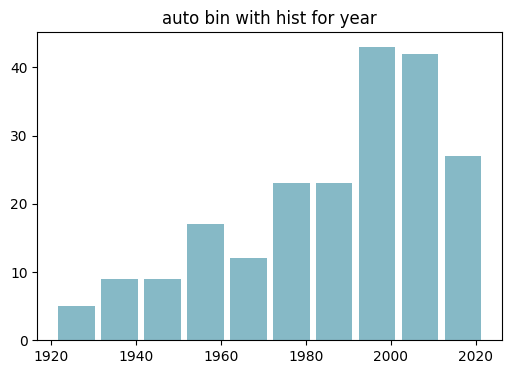

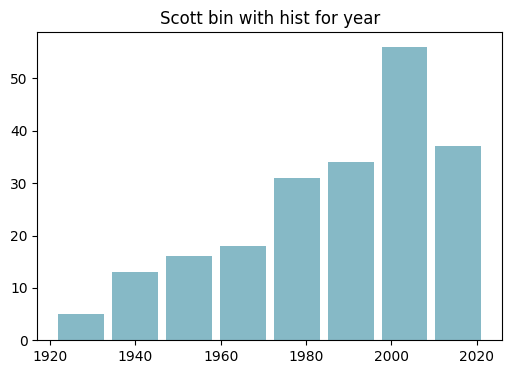

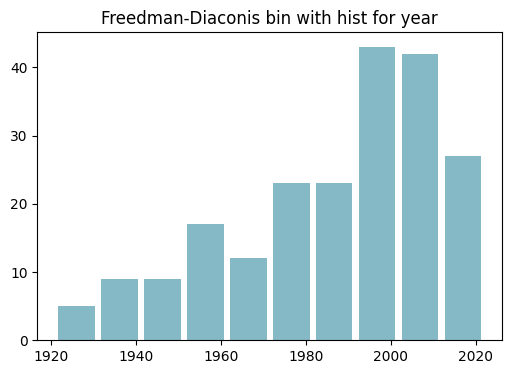

In [186]:
percentage_90s_movie = round((valid_data.query("year>=1970").shape[0]/valid_data.shape[0])*100)
print(f"{percentage_90s_movie}% of movies in the top 250 were released on or after 1970.")


# visualization for year dist 
histogram(valid_data, 'year', bins_method='auto')
histogram(valid_data, 'year', bins_method='scott')
histogram(valid_data, 'year', bins_method='fd')

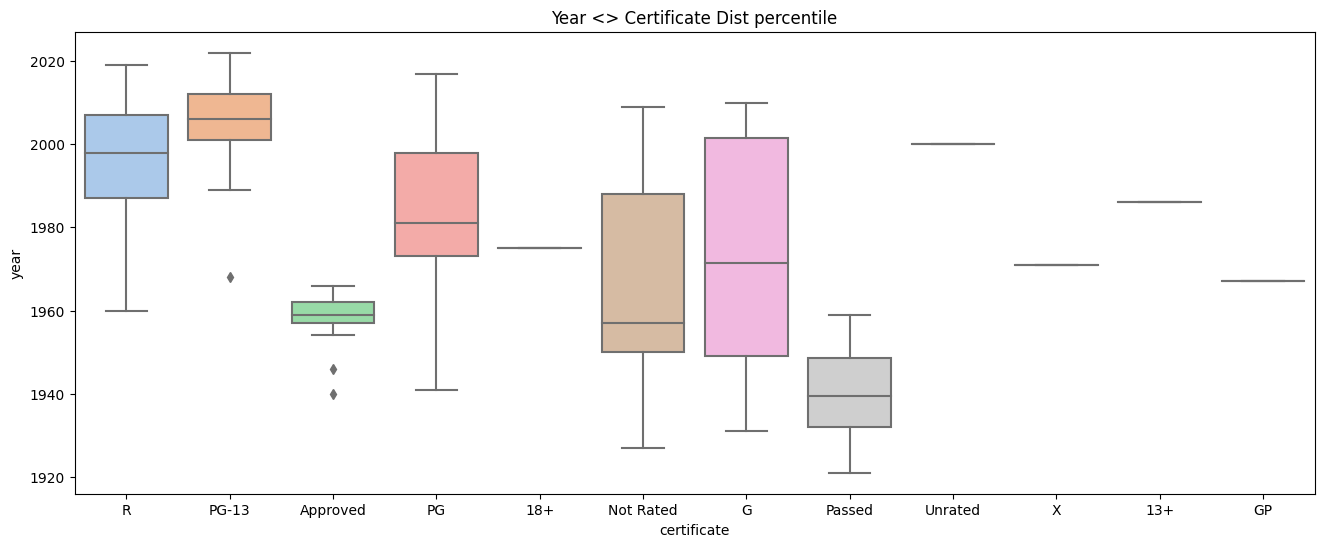

In [178]:
# Year <> Certificate Dist percentile
plt.figure(figsize=(16, 6))
sns.boxplot(x='certificate', y='year', data=valid_data, palette='pastel')
plt.title('Year <> Certificate Dist percentile')
plt.show()

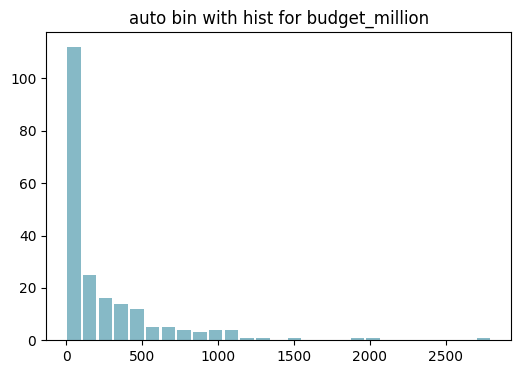

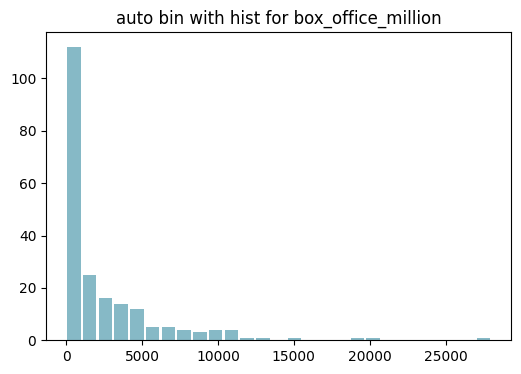

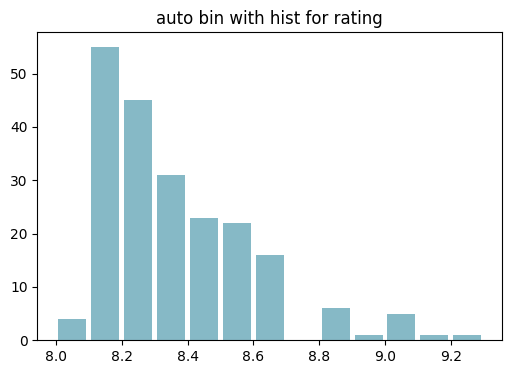

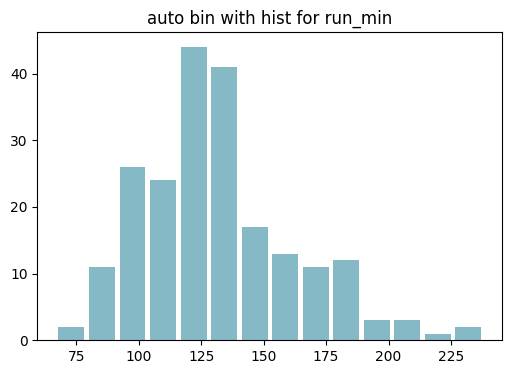

In [179]:
# visualization for budget, box_office, rating, run_min
histogram(valid_data, 'budget_million', bins_method='auto')

histogram(valid_data, 'box_office_million', bins_method='auto')

histogram(valid_data, 'rating', bins_method='auto')

histogram(valid_data, 'run_min', bins_method='auto')

## Most popular directors

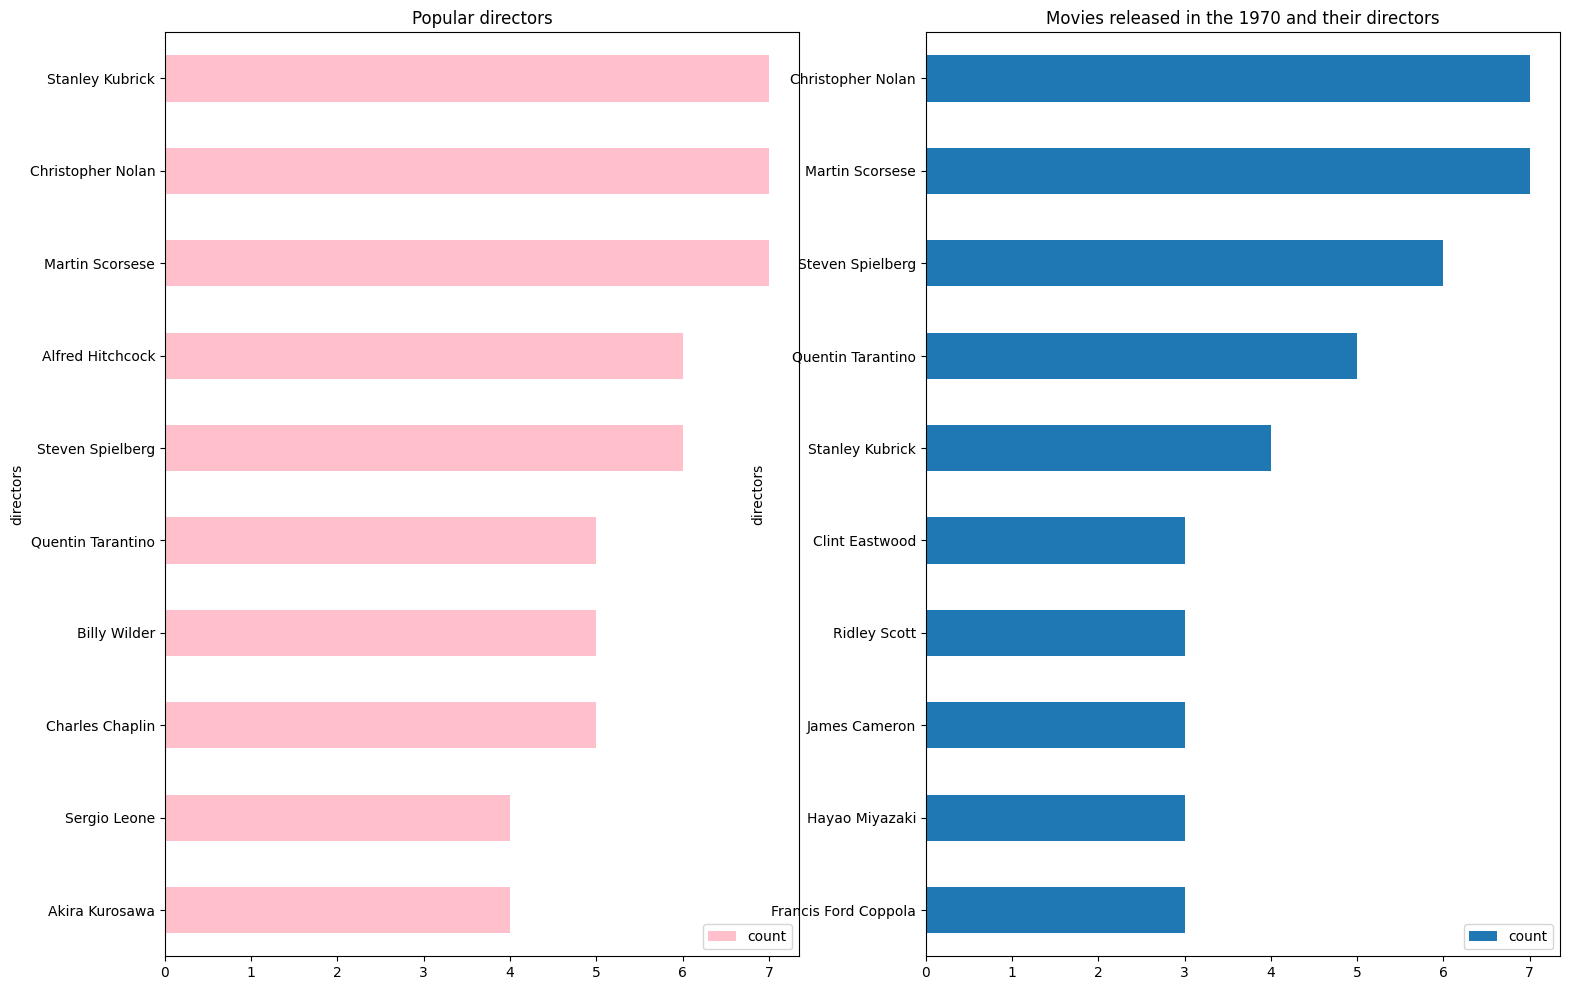

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(18, 12))  # 1 row, 2 columns

axes[0].set_title("Popular directors")
pop_directors= pd.DataFrame(valid_data["directors"].value_counts())
pop_directors.head(10).sort_values("count").plot(kind="barh", color = 'pink', ax=axes[0])

# year>=1970
axes[1].set_title("Movies released in the 1970 and their directors")
directors_post1970 = valid_data.query("year>=1970")
directors_post1970 = pd.DataFrame(directors_post1970["directors"].value_counts())
directors_post1970.head(10).sort_values("count").plot(kind="barh", ax=axes[1])
# plt.tight_layout()
plt.show()


## The most popular genre

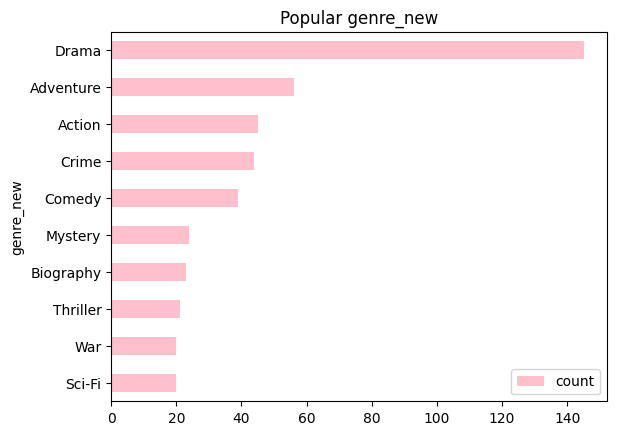

In [188]:
genre_new= pd.DataFrame(valid_data_exploded["genre_new"].value_counts())
genre_new.head(10).sort_values("count").plot(kind="barh", color = 'pink')
plt.title("Popular genre_new")
plt.show()
# genre_new

## The box_office with certificate, genre, directors

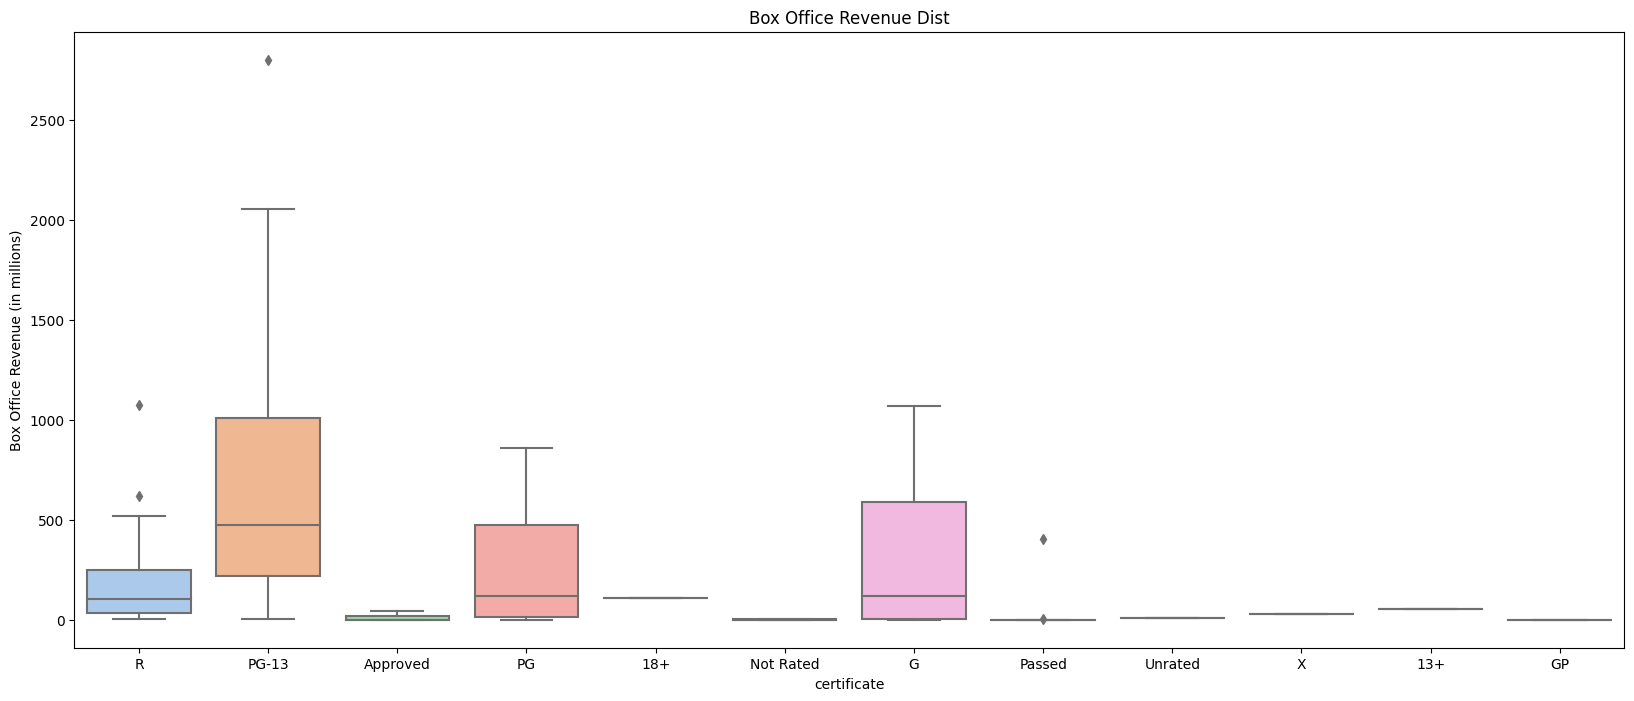

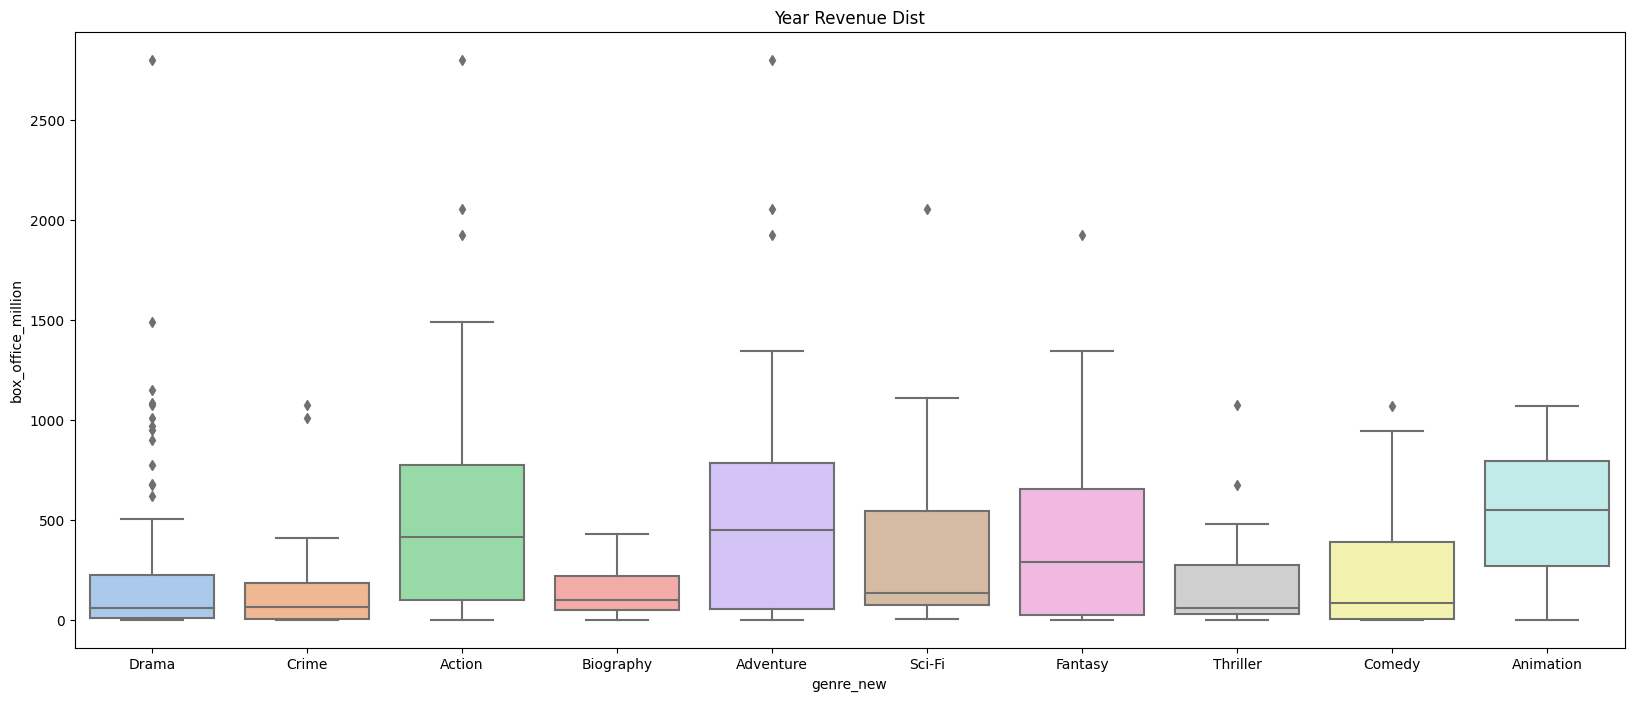

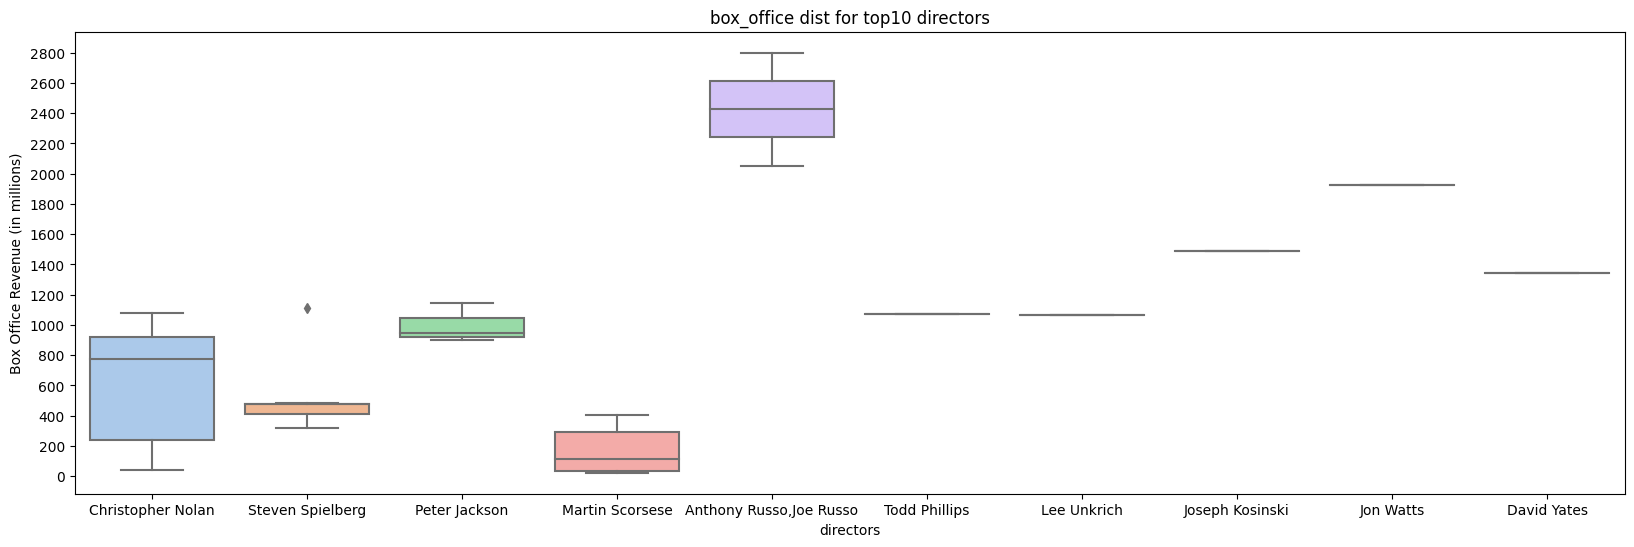

,rank,name,year,rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers,run_min,box_office_million,budget_million,genre_new
77,78,Avengers: Endgame,2019,8.4,"Action,Adventure,Drama",PG-13,3h 1m,Avenge the fallen.,356000000.0,2.799439e+09,"Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chr...","Anthony Russo,Joe Russo","Christopher Markus,Stephen McFeely,Stan Lee",181,2799.4391,356.0,"[Action, Adventure, Drama]"


In [191]:
# box_office by certificate
plt.figure(figsize=(20, 8))
sns.boxplot(x='certificate', y='box_office_million', data=valid_data, palette='pastel')
# plt.yticks(range(0, int(valid_data['box_office_million'].max() + 50), 50))
plt.ylabel('Box Office Revenue (in millions)') 

plt.title('Box Office Revenue Dist')
plt.show()

# box_office by genre
plt.figure(figsize=(20, 8))
genre_box_office = valid_data_exploded.groupby('genre_new')['box_office'].sum()
top_10_genres = genre_box_office.sort_values(ascending=False).head(10)
# print(top_10_genres.index)
top10_genre_filtered = valid_data_exploded[valid_data_exploded['genre_new'].isin(top_10_genres.index)]
sns.boxplot(x='genre_new', y='box_office_million', data=top10_genre_filtered, palette='pastel')
plt.title('Year Revenue Dist')
plt.show()

# box_office dist for top10 directors
plt.figure(figsize=(20, 6))
directors_box_office = valid_data_exploded.groupby('directors')['box_office'].sum()
top_10_directors = directors_box_office.sort_values(ascending=False).head(10)
top_d = valid_data[valid_data["directors"].isin(top_10_directors.index)]
# print(top_d)
sns.boxplot(x='directors', y='box_office_million', data=top_d, palette='pastel')
plt.yticks(range(0, int(top_d['box_office_million'].max() + 200), 200))
plt.ylabel('Box Office Revenue (in millions)') 
plt.title("box_office dist for top10 directors")
plt.show()

# plt.figure(figsize=(16, 6))
# sns.violinplot(x='certificate', y='box_office', data=valid_data, palette='pastel')
# plt.show()

valid_data[valid_data['box_office_million'] == valid_data['box_office_million'].max()]

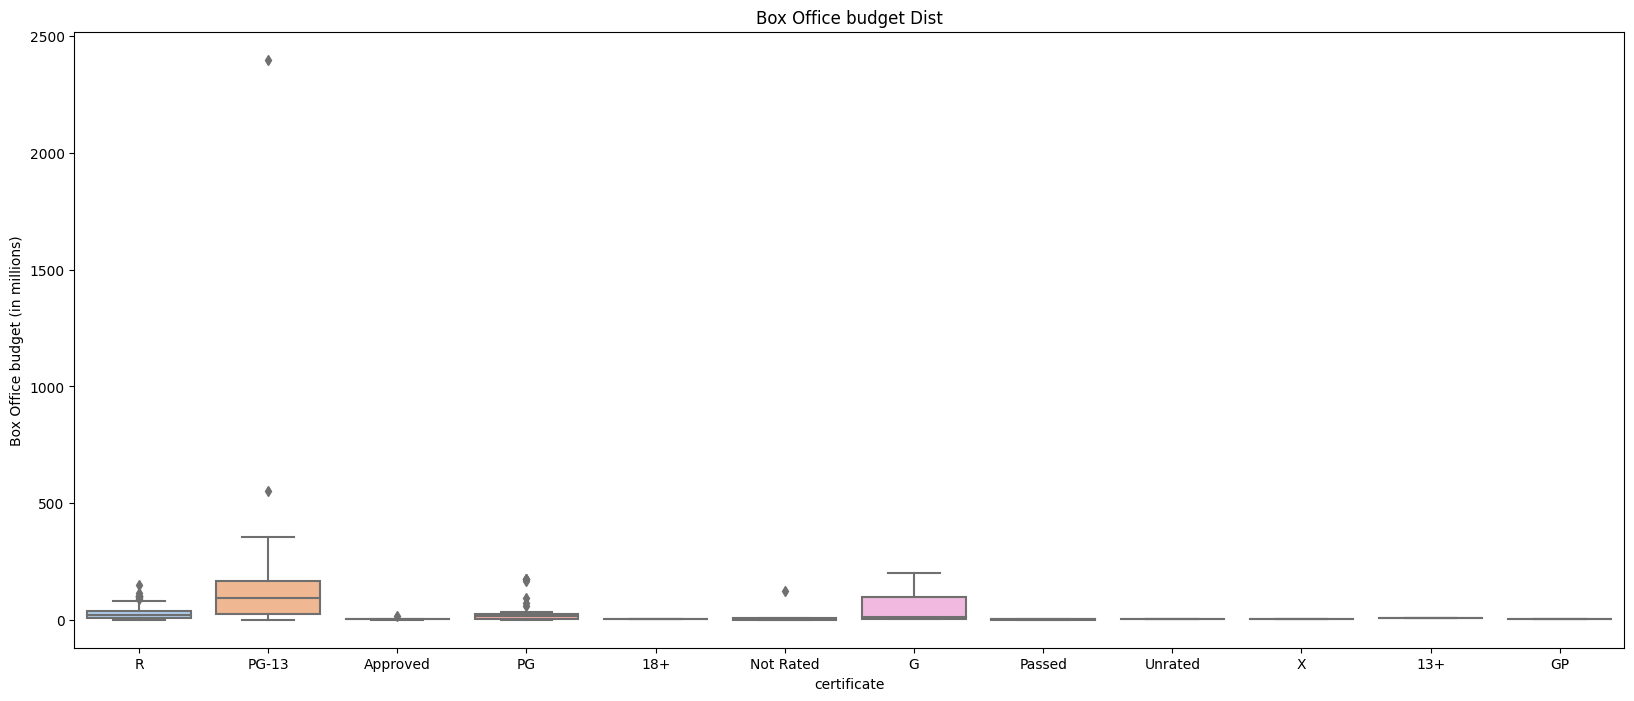

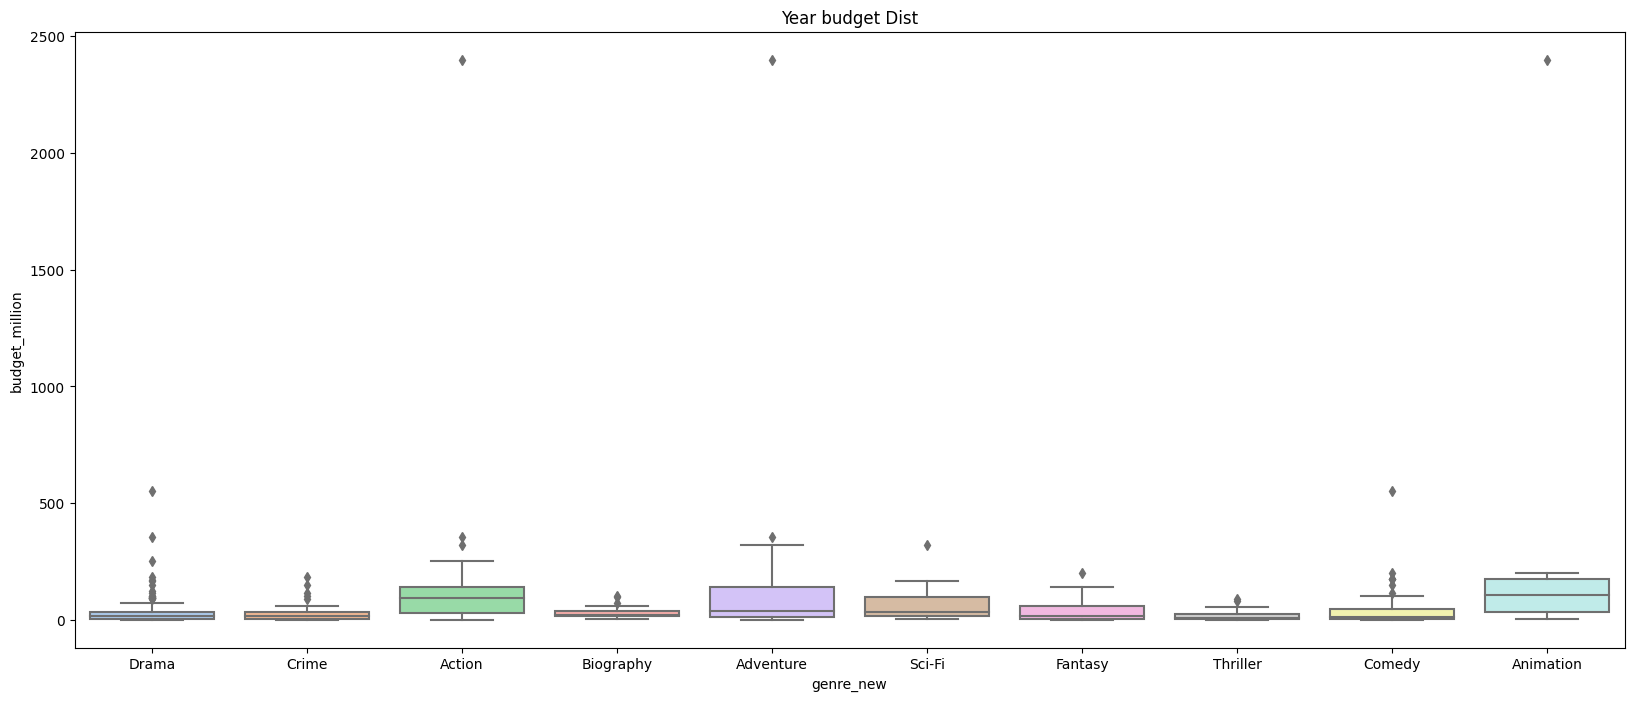

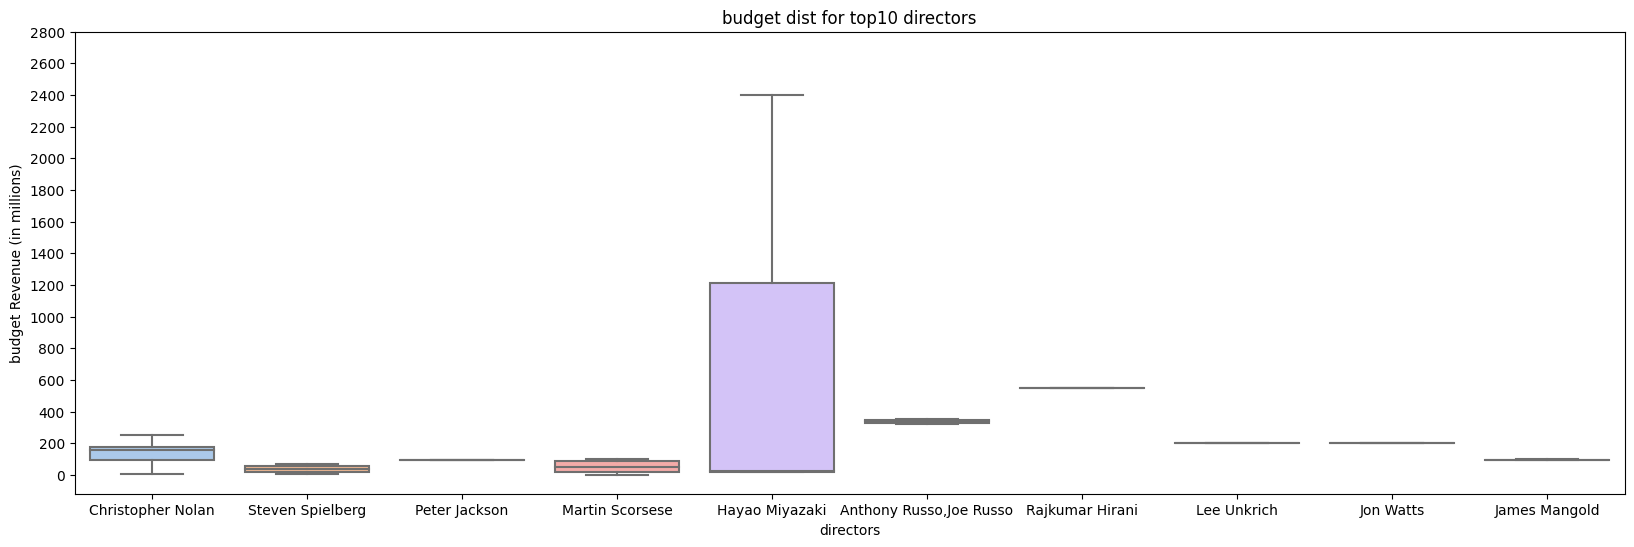

,rank,name,year,rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers,run_min,box_office_million,budget_million,genre_new
78,79,Princess Mononoke,1997,8.4,"Animation,Action,Adventure",PG-13,2h 14m,Live on.,2.400000e+09,170005875.0,"Yôji Matsuda,Yuriko Ishida,Yûko Tanaka,Billy C...",Hayao Miyazaki,"Hayao Miyazaki,Neil Gaiman",134,170.005875,2400.0,"[Animation, Action, Adventure]"


In [192]:
# budget_million by certificate
plt.figure(figsize=(20, 8))
sns.boxplot(x='certificate', y='budget_million', data=valid_data, palette='pastel')
# plt.yticks(range(0, int(valid_data['box_office_million'].max() + 50), 50))
plt.ylabel('budget (in millions)') 
plt.title('budget Dist')
plt.show()

# box_office by genre
plt.figure(figsize=(20, 8))
genre_box_office = valid_data_exploded.groupby('genre_new')['budget'].sum()
top_10_genres = genre_box_office.sort_values(ascending=False).head(10)
# print(top_10_genres.index)
top10_genre_filtered = valid_data_exploded[valid_data_exploded['genre_new'].isin(top_10_genres.index)]
sns.boxplot(x='genre_new', y='budget_million', data=top10_genre_filtered, palette='pastel')
plt.title('Year budget Dist')
plt.show()

# box_office dist for top10 directors
plt.figure(figsize=(20, 6))
directors_box_office = valid_data_exploded.groupby('directors')['budget'].sum()
top_10_directors = directors_box_office.sort_values(ascending=False).head(10)
top_d = valid_data[valid_data["directors"].isin(top_10_directors.index)]
# print(top_d)
sns.boxplot(x='directors', y='budget_million', data=top_d, palette='pastel')
plt.yticks(range(0, int(top_d['box_office_million'].max() + 200), 200))
plt.ylabel('budget Revenue (in millions)') 
plt.title("budget dist for top10 directors")
plt.show()

# plt.figure(figsize=(16, 6))
# sns.violinplot(x='certificate', y='box_office', data=valid_data, palette='pastel')
# plt.show()

valid_data[valid_data['budget_million'] == valid_data['budget_million'].max()]

# Correlation analysis

In [18]:
# clean_data_exploded
valid_data.columns

Index(['rank', 'name', 'year', 'rating', 'genre', 'certificate', 'run_time',
       'tagline', 'budget', 'box_office', 'casts', 'directors', 'writers',
       'run_min', 'genre_new'],
      dtype='object')

In [195]:
print(valid_data_exploded['certificate'].value_counts())
print(valid_data_exploded['genre_new'].value_counts())

# onehot encode 编码
df_dummies = pd.get_dummies(valid_data_exploded, columns=['certificate'], drop_first=False)
# 现在可以将df_dummies作为训练模型的数据集
# print(df_dummies)

certificate
R            213
PG            88
PG-13         85
G             46
Approved      34
Passed        29
Not Rated     21
X              2
13+            2
GP             2
18+            1
Unrated        1
Name: count, dtype: int64
genre_new
Drama        145
Adventure     56
Action        45
Crime         44
Comedy        39
Mystery       24
Biography     23
Thriller      21
Sci-Fi        20
War           20
Animation     18
Romance       16
Fantasy       13
History        8
Family         8
Western        7
Horror         5
Music          4
Sport          4
Film-Noir      3
Musical        1
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


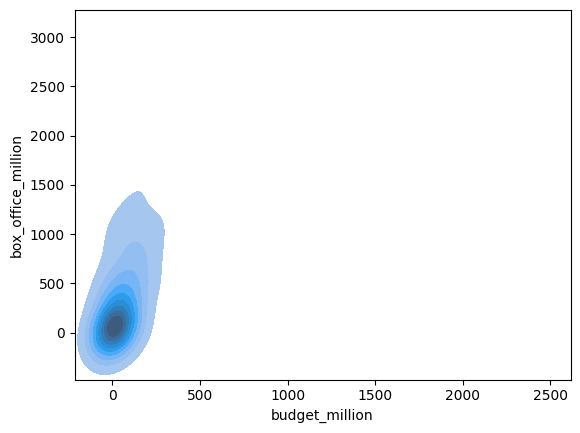

The Pearson correlation coefficient between budget_million and box_office_million is 0.25


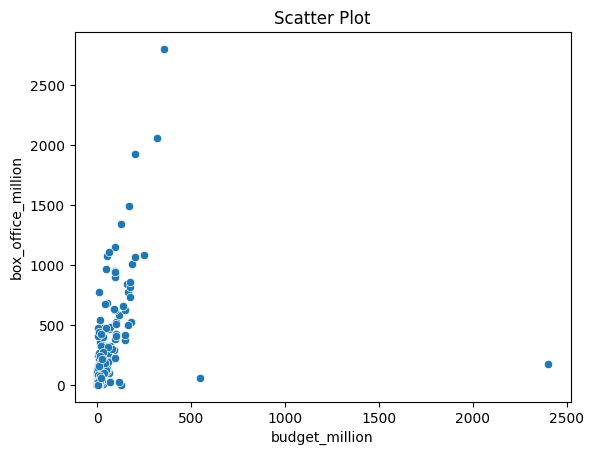

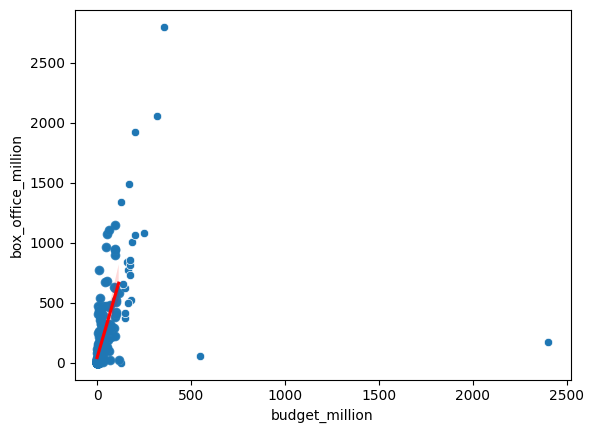

In [281]:
col_x, col_y, draw_data = 'budget_million', 'box_office_million', valid_data
# clean_data['genre'] = clean_data['genre'].apply(lambda x: hash(x) % 200) # set to 200 genres
# col_x, col_y, draw_data = 'genre_new', 'rating', clean_data_exploded

X = draw_data[col_x] 
Y = draw_data[col_y]

# kde plot
sns.kdeplot(x=X, y=Y, fill=True)
plt.show()

# Pearson coefficient
correlation = X.corr(Y)
print(f'The Pearson correlation coefficient between {col_x} and {col_y} is {correlation:.2f}')

# scatter plot
# plt.figure(figsize=(4,3))
sns.scatterplot(data=draw_data, x=X, y=Y)
# sns.regplot(x=X, y=Y, line_kws={'color': 'red'})
plt.autoscale()
plt.title(f'Scatter Plot')
plt.show()



Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_data = draw_data[(X >= lower_bound) & (X <= upper_bound)]

# linear regression
# plt.figure(figsize=(6,3))
sns.scatterplot(data=draw_data, x=X, y=Y)
sns.regplot(x=filtered_data[col_x], y=filtered_data[col_y], line_kws={'color': 'red'})
plt.show()

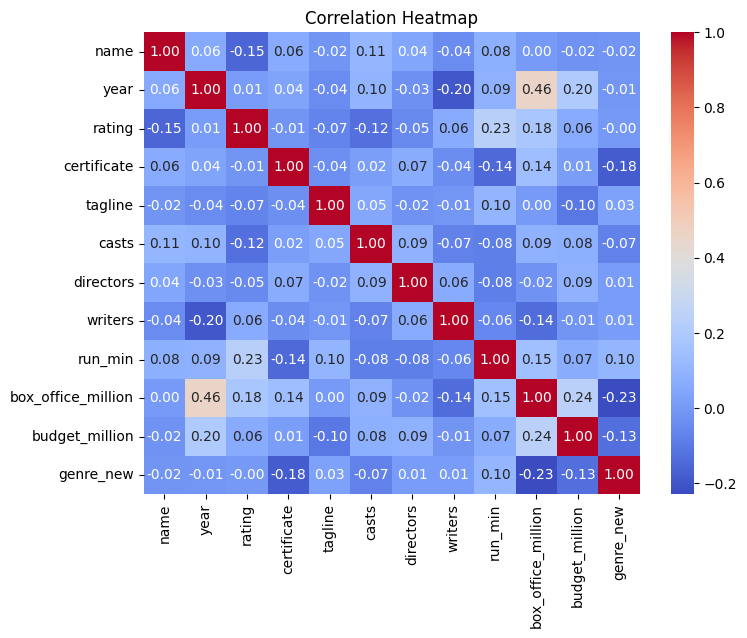

In [204]:
# get data
feature_data = valid_data_exploded.copy()

# process category features
feature_data['genre_new'] = feature_data['genre_new'].apply(lambda x: hash(x) % 200) # set to 200 category
feature_data['certificate'] = feature_data['certificate'].apply(lambda x: hash(x) % 15) #set to 15 category
feature_data['directors'] = feature_data['directors'].apply(lambda x: hash(x) % 1000)
feature_data['writers'] = feature_data['writers'].apply(lambda x: hash(x) % 1000)
feature_data['casts'] = feature_data['casts'].apply(lambda x: hash(x) % 1000)
feature_data['name'] = feature_data['name'].apply(lambda x: hash(x) % 1000)
feature_data['tagline'] = feature_data['tagline'].apply(lambda x: hash(x) % 1000)

# 'budget_million', 'box_office_million'
# process numeric features
# feature_data['run_min'] = pd.to_numeric(feature_data['run_min'], errors='coerce')
# feature_data['budget'] = pd.to_numeric(feature_data['budget'], errors='coerce')
# feature_data['box_office'] = pd.to_numeric(feature_data['box_office'], errors='coerce')
# feature_data['budget_million'] = pd.to_numeric(feature_data['budget_million'], errors='coerce')
# feature_data['box_office_million'] = pd.to_numeric(feature_data['box_office_million'], errors='coerce')
# feature_data['year'] = pd.to_numeric(feature_data['year'], errors='coerce')
# feature_data['rating'] = pd.to_numeric(feature_data['rating'], errors='coerce')

feature_data.columns = feature_data.columns.astype(str)

# heatmap
draw_d = feature_data.drop(columns=['rank', 'genre', 'run_time', 'box_office', 'budget'])
feature_data[feature_data.columns]

corr_matrix = draw_d.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.xticks(np.arange(len(corr_matrix.columns)) + 0.5, corr_matrix.columns)
plt.yticks(np.arange(len(corr_matrix.columns)) + 0.5, corr_matrix.columns)
plt.title('Correlation Heatmap')
plt.show()

# Feature analysis 特征重要性分析

In [234]:
# 训练数据
# train and test
test_data = feature_data[-20:]
train_data = feature_data[:-20]

y = train_data['box_office_million']
test_y = test_data['box_office_million']

# drop unused column
x = train_data.drop(columns=['box_office', 'budget', 'box_office_million', 'rank', 'genre', 'run_time'])
test_x = test_data.drop(columns=['box_office', 'budget','box_office_million', 'rank', 'genre', 'run_time'])

print(x.columns)
print(test_y.shape, x.shape, train_data.shape)

Index(['name', 'year', 'rating', 'certificate', 'tagline', 'casts',
       'directors', 'writers', 'run_min', 'budget_million', 'genre_new'],
      dtype='object')
(20,) (504, 11) (504, 17)


                Importance
Feature                   
budget_million    0.667098
year              0.110839
certificate       0.071062
rating            0.038135
directors         0.029364
tagline           0.024374
run_min           0.020792
name              0.016646
writers           0.012201
casts             0.009182
genre_new         0.000308


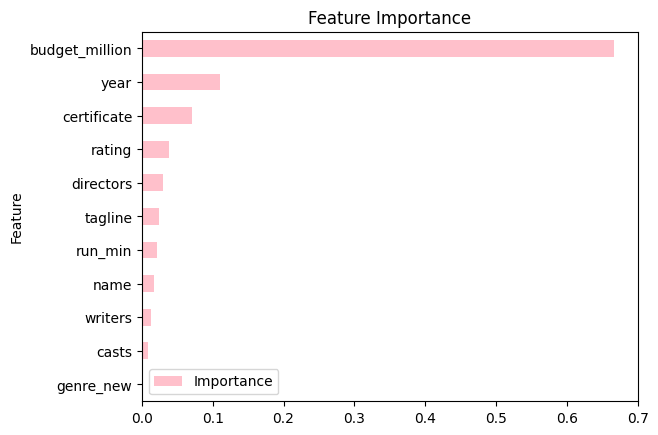

In [214]:
# model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=400)

# train
model.fit(x, y)

# 获取特征重要性
importance = model.feature_importances_
feature_names = x.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# remove index 1,2,3
importance_df = importance_df.set_index('Feature') 
print(importance_df)


importance_df.sort_values("Importance").plot(kind="barh", color = 'pink')
plt.title('Feature Importance')
plt.show()

In [ ]:
# # kmeans
# from sklearn.cluster import KMeans

# # 生成 2D 随机数据
# np.random.seed(42)
# data = np.random.rand(100, 2)  # 100 个二维向量

# # 训练 K-Means 进行向量量化（K=5）
# kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
# kmeans.fit(data)

# # codebook 聚类中心
# codebook = kmeans.cluster_centers_
# # print(codebook)

# # 将数据量化（映射到最近的码本向量）
# labels = kmeans.predict(data)
# quantized_data = codebook[labels]  # 用码本重建数据
# # print(quantized_data)

# # visual
# plt.scatter(data[:, 0], data[:, 1], c='gray', label="Original Data")
# plt.scatter(quantized_data[:, 0], quantized_data[:, 1], c='red', label="Quantized Data")
# # plt.scatter(codebook[:, 0], codebook[:, 1], c='blue', marker='X', s=200, label="Codebook")
# plt.legend()
# plt.title("Vector Quantization using K-Means")
# plt.show()


# Auto ML

In [208]:
# !pip uninstall -y scikit-learn
# !pip install -U scikit-learn==1.5.2
# !pip install scikit-learn==0.24.2
# !pip show scikit-learn
# !conda list scikit-learn
# !conda activate myenv

# import sys
# !python -m pip install --force-reinstall scikit-learn==1.5.2
# !{sys.executable} -m pip install -U scikit-learn==1.5.2

# !pip install -U scikit-learn==1.5.2
import sklearn
print(sklearn.__version__)

1.5.2


In [237]:
autogluon_train = x.join(y, how='inner')
autogluon_train

,name,year,rating,certificate,tagline,casts,directors,writers,run_min,budget_million,genre_new,box_office_million
0,900,1994,9.3,5,468,906,230,537,142,25.000,173,28.884504
1,523,1972,9.2,5,388,343,801,555,175,6.000,137,250.341816
1,523,1972,9.2,5,388,343,801,555,175,6.000,137,250.341816
1,523,1972,9.2,5,388,343,801,555,175,6.000,173,250.341816
1,523,1972,9.2,5,388,343,801,555,175,6.000,173,250.341816
...,...,...,...,...,...,...,...,...,...,...,...,...
236,32,1940,8.1,2,328,434,776,913,130,1.288,53,0.072275
236,32,1940,8.1,2,328,434,776,913,130,1.288,89,0.072275
236,32,1940,8.1,2,328,434,776,913,130,1.288,89,0.072275
236,32,1940,8.1,2,328,434,776,913,130,1.288,89,0.072275


In [239]:
autogluon_train.columns

Index(['name', 'year', 'rating', 'certificate', 'tagline', 'casts',
       'directors', 'writers', 'run_min', 'budget_million', 'genre_new',
       'box_office_million'],
      dtype='object')

In [242]:
from autogluon.tabular import TabularDataset, TabularPredictor

# metrics = ['roc_auc', "f1", "recall", "recall"] 
# define data
train_ds = TabularDataset(autogluon_train)
label = 'box_office_million'
save_path = 'work_dir'

# fit
# predictor = TabularPredictor(label="label").fit(zuhe_train_Tab,presets="high_quality",excluded_model_types = ['KNN'])
predictor = TabularPredictor(label=label, path=save_path).fit(train_ds)

# predictor = TabularPredictor.load(save_path) 加载模型

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.70 GB / 31.35 GB (94.7%)
Disk Space Avail:   19.39 GB / 19.52 GB (99.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference spee

[1000]	valid_set's rmse: 41.9404
[2000]	valid_set's rmse: 40.3266
[3000]	valid_set's rmse: 39.9982
[4000]	valid_set's rmse: 39.9214
[5000]	valid_set's rmse: 39.8961
[6000]	valid_set's rmse: 39.8982
[7000]	valid_set's rmse: 39.8944
[8000]	valid_set's rmse: 39.8926


	-39.8906	 = Validation score   (-root_mean_squared_error)
	5.63s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 31.8074
[2000]	valid_set's rmse: 31.769


	-31.7673	 = Validation score   (-root_mean_squared_error)
	3.11s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-35.3172	 = Validation score   (-root_mean_squared_error)
	0.74s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: CatBoost ...
	-27.1998	 = Validation score   (-root_mean_squared_error)
	7.57s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-76.0768	 = Validation score   (-root_mean_squared_error)
	0.69s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-93.514	 = Validation score   (-root_mean_squared_error)
	1.6s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-36.4008	 = Validation score   (-root_mean_squared_error)
	0.57s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-29.1086	 = Validation score   (-root_mean_squared_error)
	52.85s	 = Training   runtime
	0.01s	 = Validation

In [243]:
# ======= check
predictor.problem_type
print(predictor.feature_metadata)

('float', []) : 2 | ['rating', 'budget_million']
('int', [])   : 9 | ['name', 'year', 'certificate', 'tagline', 'casts', ...]


In [244]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val              eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -21.251206  root_mean_squared_error       0.014558  60.438972                0.000501           0.014722            2       True         12
1              CatBoost  -27.199769  root_mean_squared_error       0.002400   7.568973                0.002400           7.568973            1       True          6
2        NeuralNetTorch  -29.108596  root_mean_squared_error       0.007922  52.845759                0.007922          52.845759            1       True         10
3         LightGBMLarge  -29.362962  root_mean_squared_error       0.009665   2.183082                0.009665           2.183082            1       True         11
4              LightGBM  -31.767310  root_mean_squared_error       0.047065   3.112060                0.047065   

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesMSE': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': -112.18967560346962,
  'KNeighborsDist': -54.13777298079888,
  'LightGBMXT': -39.89060720755394,
  'LightGBM': -31.767310370208033,
  'RandomForestMSE': -35.3172242313032,
  'CatBoost': -27.1997690174751,
  'ExtraTreesMSE': -76.07682695727618,
  'NeuralNetFastAI': -93.51401249998948,
  'XGBoost': -36.40083011121998,
  'NeuralNetTorch': -29.108595933641816,
  'LightGBMLarge': -29.362961971350476,
  'WeightedEnsemble_L2': -21.25120606588843},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': ['KNeighb

In [245]:
# evaluation
# 不同模型在测试集的指标排名
display(predictor.leaderboard(
    test_data, 
    extra_metrics = ['root_mean_squared_error', 'mean_squared_error', 'mean_absolute_error', 
                     'median_absolute_error', 'mean_absolute_percentage_error', 'r2'], silent=True))

# 最优模型在测试集的多种结果指标
predictor.evaluate(test_data)

##等价于如下步骤
# y_test = test_data[label]                    #真实值
# test_data_nolab = test_data.drop(columns=[label])  
# test_data_nolab.head()
# y_pred = predictor.predict(test_data_nolab)  #预测值
# predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
# predictor.predict_proba(test_data_nolab)     #预测概率


# predict by LightGBM
# predictor.predict(test_data, model='LightGBM')

,model,score_test,root_mean_squared_error,mean_squared_error,mean_absolute_error,median_absolute_error,mean_absolute_percentage_error,r2,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist,-195.227293,-195.227293,-38113.696123,-168.389079,-139.453782,-14722.169068,-0.781932,-54.137773,root_mean_squared_error,0.002045,0.003735,0.009519,0.002045,0.003735,0.009519,1,True,2
1,KNeighborsUnif,-196.996202,-196.996202,-38807.503524,-171.895824,-150.022178,-35544.345479,-0.814370,-112.189676,root_mean_squared_error,0.002108,0.003425,0.008314,0.002108,0.003425,0.008314,1,True,1
2,WeightedEnsemble_L2,-242.687691,-242.687691,-58897.315407,-167.777972,-92.156176,-10592.595825,-1.753630,-21.251206,root_mean_squared_error,0.024722,0.014558,60.438972,0.003307,0.000501,0.014722,2,True,12
3,ExtraTreesMSE,-248.377744,-248.377744,-61691.503583,-169.095961,-113.203663,-16008.037730,-1.884267,-76.076827,root_mean_squared_error,0.084449,0.088492,0.692011,0.084449,0.088492,0.692011,1,True,7
4,CatBoost,-256.395785,-256.395785,-65738.798403,-166.109504,-64.459399,-8729.374332,-2.073491,-27.199769,root_mean_squared_error,0.009075,0.002400,7.568973,0.009075,0.002400,7.568973,1,True,6
5,NeuralNetTorch,-270.232824,-270.232824,-73025.779097,-190.616984,-115.238413,-11079.425742,-2.414180,-29.108596,root_mean_squared_error,0.010295,0.007922,52.845759,0.010295,0.007922,52.845759,1,True,10
6,RandomForestMSE,-278.916332,-278.916332,-77794.320236,-182.761999,-94.131862,-2782.871151,-2.637124,-35.317224,root_mean_squared_error,0.090415,0.091243,0.736123,0.090415,0.091243,0.736123,1,True,5
7,LightGBM,-279.895552,-279.895552,-78341.519853,-204.094214,-118.710160,-2016.330692,-2.662707,-31.767310,root_mean_squared_error,0.047011,0.047065,3.112060,0.047011,0.047065,3.112060,1,True,4
8,LightGBMLarge,-280.832723,-280.832723,-78867.018375,-206.560820,-183.346132,-1388.149207,-2.687275,-29.362962,root_mean_squared_error,0.025139,0.009665,2.183082,0.025139,0.009665,2.183082,1,True,11
9,NeuralNetFastAI,-300.326926,-300.326926,-90196.262591,-169.756321,-44.573967,-201.697537,-3.216952,-93.514012,root_mean_squared_error,0.016264,0.011778,1.598577,0.016264,0.011778,1.598577,1,True,8


{'root_mean_squared_error': -242.6876910912002,
 'mean_squared_error': -58897.31540717782,
 'mean_absolute_error': -167.77797218673405,
 'r2': -1.7536304790786974,
 'pearsonr': -0.2302905578059601,
 'median_absolute_error': -92.15617610034181}

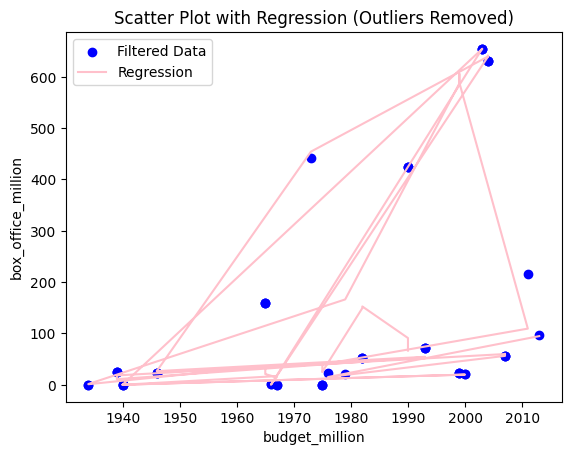

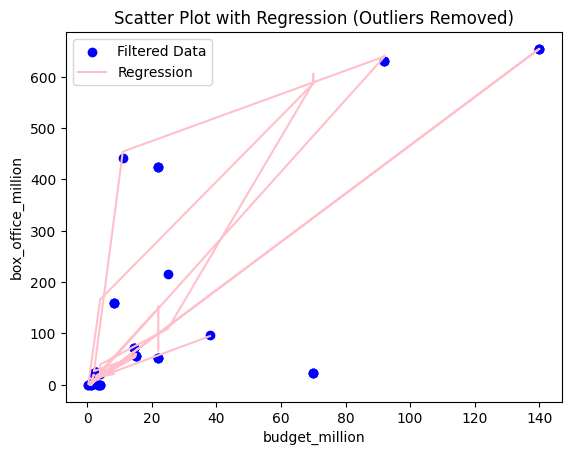

In [276]:
test_data2 = feature_data[-50:]
pred_y = predictor.predict(test_data2, model='NeuralNetTorch')


# 其实是超平面，但这里只画出单维度的回归线
plt.scatter(test_data2['year'], test_data2['box_office_million'], color='blue', label='Filtered Data')
plt.plot(test_data2['year'], pred_y, color='pink', label='Regression')
plt.title('Scatter Plot with Regression (Outliers Removed)')
plt.xlabel('budget_million')
plt.ylabel('box_office_million')
plt.legend()
plt.show()

# 其实是超平面，但这里只画出单维度的回归线
plt.scatter(test_data2['budget_million'], test_data2['box_office_million'], color='blue', label='Filtered Data')
plt.plot(test_data2['budget_million'], pred_y, color='pink', label='Regression')
plt.title('Scatter Plot with Regression (Outliers Removed)')
plt.xlabel('budget_million')
plt.ylabel('box_office_million')
plt.legend()
plt.show()

# test_data2